# Documentation: `AutoDiff`

## Table of Contents
1. [Introduction](#introduction)
2. [How To Use AutoDiff](#how-to)
    - [Installing the Package](#installation)
    - [Demo](#demo)
2. [Background](#background)
4. [Software Organization](#SoftwareOrganization)
    - [Directory Structure](#structure)
    - [Modules](#modules)
    - [Test Suite](#tests)
    - [Distribution](#distribution)
    - [Installation](#installation)
5. [Implementation](#implementation)
    - [Core Data Structure](#p1)
    - [Major Class](#p2)
    - [Method and Name Attributes in AutoDiff Class](#p3)
    - [Other Functions](#p4)
    - [External Dependences](#p5)
6. [Future](#future)

<a id="introduction"></a>
## Introduction 

It goes without saying that taking derivatives is an essential operation in numerical methods, optimization, and science. From a computational perspective, however, calculating a derivative can be a difficult.

If one uses **finite differences** (i.e. $f'(x) \approx (f(x+\epsilon) - f(x))/\epsilon)$), one needs to choose $\epsilon$ appropriately. If $\epsilon$ is too large, the approximation is poor. If $\epsilon$ is too small, one introduces round-off errors.

Alternatively, if one uses **symbolic differentiation** (i.e. an algorithm that produces the derivative as a symbolic function), the problem becomes computationally infeasible when you either have functions with many inputs or want to take high order derivatives. These two scenarios occur often in applications.

**Automatic differentiation** overcomes these challenges by providing both quick and accurate derivatives.

<a id="how-to"></a>
## How To Use `autoder`

<a id="installation"></a>
### Installing the Package
You can use pip to install the test `autoder` package. 

```
pip install -i https://test.pypi.org/simple/ autoder
```

<a id="demo"></a>
### Demo for Automatic Differentiation

To use the package, first import the `variables` and `AD_numpy` modules.

In [24]:
import sys
sys.path.insert(0, '../AutoDiff')
import AutoDiff.variables as v
import AutoDiff.AD_numpy as np

The core object in `autoder` is the `Variable` class. They allow numbers to have both objects and derivatives.

In [18]:
# Initialize a variable with a name and a value
x = v.Variable('x', 3)
y = v.Variable('y', 4)

Functions of `Variable` instances return another `Variable`. Functions such as `sin` and `log` can be found in the `AD_numpy` module.

In [19]:
f = x**2+y**2+np.sin(x)
print(f)

Variable name: f(f(f(x),f(y)),x), Value: 25.14112000805987, Derivatives: {'y': 8, 'x': 5.010007503399555}


To return the partial derivatices, use the `partial_der` function

In [20]:
f.partial_der(x)

5.010007503399555

To return the jacobian, call the `jacobian` function

In [21]:
f.jacobian()

{'y': 8, 'x': 5.010007503399555}

To demonstrate the functionality of this package, here is a simple implementation of gradient descent to find the minimal parameters of $f=(x+3)^2+(y-5)^2$.

In [22]:
# Implementation of gradient descent
function = lambda x, y: (x+3)**2+(y-5)**2
params = [3,4]
print('initial parameters', params)
x = v.Variable('x', params[0])
y = v.Variable('y', params[1])
for epoch in range(1000):
    grad = function(x,y).jacobian()
    for idx, g in enumerate(grad.values()): 
        params[idx] = params[idx] - 0.01*g
    x = v.Variable('x', params[0])
    y = v.Variable('y', params[1])
print('final parameters',params)

initial parameters [3, 4]
final parameters [1393926277.8034523, -1393926275.8034523]


<a id="demo"></a>
### Demo for Optimization

To use the package, first import the Optimizer module.

In [25]:
sys.path.insert(0, '../Implementation')
import Optimizer as op

Optimizer module has various methods for optimizations, such as min_conjugate_gradient, min_steepestgradient, and min_BFGS. 

In [34]:
print(dir(op))

['MAXITER', 'PRECISION', 'Result', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_get_grad', '_line_search', '_update_hessian', 'findroot', 'min_BFGS', 'min_conjugate_gradient', 'min_gradientdescent', 'min_newton', 'min_steepestdescent', 'minimize', 'np', 'root_BFGS', 'root_SGD', 'root_gradientdescend', 'root_newton', 'root_secant_method', 'time']


Once choosing which optimization method to use, a user can initialize the function and its initial values. 

In [28]:
# an example function
f = lambda x, y, z: (x-4)**2 + (y-3)**2 + (z-2)**2
op.min_conjugate_gradient(f, [3, 2, 1], 1e-6, 50)

To demonstrate the functionality of this package, here is a simple implementation of min_conjugate_gradient for $(x-4)^2+ (y-3)^2 + (z-2)^2$

## We can display the result of min_conjugate_gradient, as an example result and what it shows.

<a name="background"></a>
## Background

Automatic differentiation computes derivatives recursively using the chain rule. All functions are either an **"elementary" function**, for which we know the derivative, or a composition of elementary functions. To calculate the derivative of a composite function $f(g(x))$, we apply the chain rule as follows:

$$
\frac{df}{dx} = \frac{df}{dg}\frac{dg}{dx}
$$

The chain rule can be applied recursively, which we exploit in automatic differentiation. For example, if we have a complex composite function $f(g(h(x)))$, we can compute f'(x) by first calculating

$$
\frac{dg}{dx} = \frac{dg}{dh}\frac{dh}{dx}
$$

and then plugging this derivative into 

$$
\frac{df}{dx} = \frac{df}{dg}\frac{dg}{dx}
$$

This is in fact a simple example of **forward-mode** automatic differentiation. In general, to conduct forward mode automatic differentiation, we represent our function to differentiate as a **computational graph**. The computational graph  captures the inputs and outputs of our elementary functions. In an example that can be found [here](http://www.columbia.edu/~ahd2125/post/2015/12/5/), we can represent $f(x,y)=\cos(x)\sin(y)+\frac{x}{y}$ as 

![comp-graph](figs/comp_graph_background.png)

By computing derivatives recursively using the chain rule from the inputs $x$ and $y$ to the output $f$, we can calculate the derivative over the entire graph.

This project will implement only forward-mode automatic differentiation, but as an aside, **reverse-mode automatic differentiation** begins at the output(s) of the computational graph and calculates derivates using the chain rule by traversing the graph backwards.

In terms of optimization, we implemented advanced gradient-based optimization methods such as conjugate gradient, steepest descent, and BFGS and the basic gradient descent, in order to fully utilize properties of our automatic differentiation package. The general idea to use forward-mode automatic differentiation to find out the minimum of a function in different ways. For example, the plot below shows how steepest descent and conjugate gradient finds optimum. 


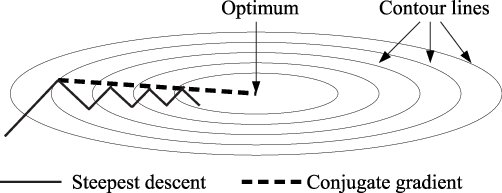

<a name="SoftwareOrganization"></a>
## Software Organization 

<a name="structure"></a>
### Directory Structure

The directory structure will be as follows

`
AutoDiff
|-README.md
|-LICENSE
|-setup.py
|-requirements.txt
|-AutoDiff
  |-__init__.py
  |-variables.py
  |-AD_numpy.py
  |-user_func.py
|-docs
  |-documentation.md
|-tests
  |-__init__.py
  |-test_variables.py
  |-test_numpy.py
  |-test_user_func.py
  |-test_derivatives.py
`

<a name="modules"></a>
### Modules

The `variables` module contains the functionality to define variables that are compatible with automatic differentiation. These variables will be passed to functions in `AD_numpy` or to functions specified by the user with `user_func`.

The `AD_numpy` module stores our mathematical functions that will overwrite the typically used numpy package such that the user can use mathematical functions on Variable instances just as they would with numeric values. 

<a name="tests"></a>
### Test Suite

We will store our tests in the `tests` module and run them using `TravisCI`.

<a name="distribution"></a>
### Distribution

The package will eventually be distributed on `PyPI`. However, it is currently only available on `test.pypi.org` to indicate that the package is not ready for wide distribution.

<a name="installation"></a>

### Installation

You can use pip to install the test `autoder` package with the following command.

```
pip install -i https://test.pypi.org/simple/ autoder
```


<a name="implementation"></a>
## Implementation 
<a id="p1"></a>

### Major data structure: Variables and the Computational Graph

Our variables will be the nodes in our computational graph. The variables will keep track of the node's value and it's derivative.

<a id="p2"></a>
### Classes

The main class that we will implement is the `Variable` class. All auto-differentiable functions will have inputs and outputs consisting of instances of the `Variable` class. The `Variable` class will be an extension on ordinary python numbers. It will store the derivative of the variable and it's actual value.

<a id="p3"></a>
### Method and Name Attributes in Variable Class
* Name Attributes

The `Variable` class will have two main instance variables, the value of the variable instance, and the derivatives of the instance.

`Variable.name`: name of the variable. When the user first instantiates a `Variable` instance, it is important that the user sets the name of the variable. This is necessary to keep track of the various variables while we calculate compound functions. Importantly, this will allow us to calculate the partial derivatives with respect to each of the instantiated `Variable` instances correctly.

`Variable.val`: value of the variables. The shape is the same as the input variable. 

`Variable.der`: value of the derivatives. The derivatives are held in a dictionary, with each key corresponding to the names of base Variable instances that we instantiated. The corresponding value pair is the partial derivative of the function with respect to the key.

* Methods

In order to override the four basic operations of elementary arithmetic (addition, subtraction, multiplication, and division), we use dunder methods within our `Variable` class. The dunder methods return new `Variable` instances with the updated value and derivatives.

* Jacobian and Partial Derivatives

The two main methods that the user will typically use are `Variable.jacobian()` and `Variabel.partial_der(x)`. The former returns the jacobian of the function that the user calcluated from `Variable` instances. The latter returns the partial derivative with respect to a specific `Variable` instance.

<a id="p4"></a>
### Other function 

* Define elementary differentiation function. 

In order to deal with the other elementary functions (exponential, logarithm, powers, roots, trigonometric functions, inverse trigonometric functions, hyperbolic functions, etc.), we will override the numpy elementary functions such that we can use it for our AutoDiff class. 

>For example, we will override the `np.sin` function such that if you use it on an `variable` instance `x` at a given value, it will return another `variable` instance with the value of $\sin(x)$, and the calculated derivative of $\dot{x}\cos(x)$ at the given value. Similarly, we will override the `np.exp` function such that if you use it on an `variable` instance `x` at a given value, it will return another `variable` instance with the value of $\exp(x)$, and the calculated derivative of $\dot{x}\exp(x)$ at the given value.

To define an auto-differentiable function, the user will pass the expression for the value and derivative to the `user_function` method, which will return a function compatible with `variable` inputs.

<a id="p5"></a>
### External dependencies 

The main and only external dependency for our package is the external numpy package. This will be specified in our setup.py file as a dependency that should be installed together with our package. The external numpy package is necessary for our the various mathematical operations necessary for Automatic Differentiation.


<a name="future"></a>
## Future
<a id="p1"></a>

<a id="p2"></a>
### Future Implementation
Subsequently, we will extend our `AutoDiff` package for vector functions of vectors. The user will be able to construct variables for vectors. This will make it easier for them when they are caluclating vector derivatives. 


### Project extension: User defined functions

In order to ensure that the usage of our own mathematical package is very intuitive, we stick to the various functions that were a part of the original numpy package. However, the user can define their own function as well. For example, imagine if a user wanted to implement the trigonometric secant function. 

```python
>>> sec = lambda x: 1/np.cos(x)
>>> sec_der = lambda x: sec(x)*np.tan(x)
>>> ad_sec = user_function(sec, sec_der)
>>> a = Variable('a', 2)
>>> x = ad_sec(a)
>>> x.val
-2.4029979617223809
>>> x.jacobian()
5.25064633769958
```
<a id="p3"></a>
### Software Changes

Once we implement the functionality allowing users to define functions, we might rewrite all of our own autodifferentiable functions with this method. This will make our test coverage increase and make our code more readable.

We will also need to refactor some of our code to account for vector valued inputs.

<a id="p4"></a>
### Primary Challenges

It might be difficult to have our functions handle both scaler and vector inputs.